<a href="https://colab.research.google.com/github/cedro3/instruct-pix2pix/blob/main/InstructPix2Pix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title **Setup**
# install pacage
!pip install diffusers transformers safetensors accelerate

# make pipeline
import torch
from diffusers import StableDiffusionInstructPix2PixPipeline
pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(
    "timbrooks/instruct-pix2pix",
    safety_checker=None, 
    torch_dtype=torch.float16
).to("cuda")

# copy github
! git clone https://github.com/cedro3/instruct-pix2pix.git
%cd instruct-pix2pix

# define function
from function import *

# make folder
! mkdir picture/results
! mkdir movie/results

In [ ]:
#@title **Select pic**
from PIL import Image
pic = '01.jpg' #@param {type:"string"}
pic_path = 'picture/pic/'+pic
image = Image.open(pic_path).resize((512, 512)).convert("RGB")
image

In [ ]:
#@title **InstructPix2Pix**
prompt = "turn her cloths into leather jacket" #@param {type:"string"}

edit_image = pipe(prompt, 
    image=image, 
    num_inference_steps=20, 
    image_guidance_scale=1.5, 
    guidance_scale=7).images[0]

name = prompt.replace(' ','_')
pic_result_path = 'picture/results/'+pic+'_'+name+'.jpg'
edit_image.save(pic_result_path)
edit_image

In [ ]:
#@title **Download result**
from google.colab import files
files.download(pic_result_path)

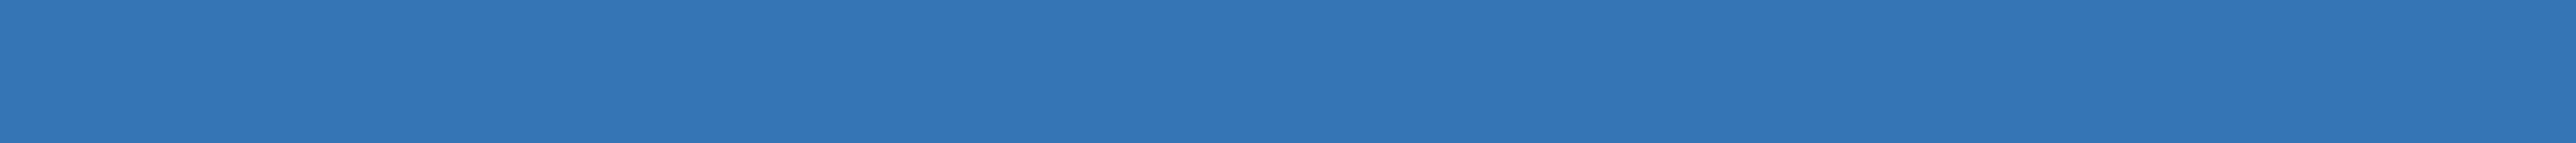

In [ ]:
#@title **video2images**

# setting
video = '01.mp4' #@param {type:"string"}
video_file ='movie/video/'+video
image_dir='movie/frames/'
image_file='%s.jpg'

# video_2_images
reset_folder('movie/frames')
fps, i, interval = video_2_images(video_file, image_dir, image_file)

# スタートフレーム表示
from google.colab.patches import cv2_imshow
img = cv2.imread('movie/frames/000000.jpg')
cv2_imshow(img)

# パラメータ表示
print('fps = ', fps)
print('frames = ', i)
print('interval = ', interval)

In [ ]:
#@title **InstructPix2Pix for images**
from PIL import Image
import glob

reset_folder('movie/images')
frames = sorted(glob.glob('movie/frames/*.jpg'))
prompt = 'Make it a Van Gogh painting' #@param {type:"string"}
for i, frame in enumerate(frames):
    image = Image.open(frame).resize((512, 512)).convert("RGB")
    edit_image = pipe(prompt, 
        image=image, 
        num_inference_steps=20, 
        image_guidance_scale=1.5, 
        guidance_scale=7).images[0]
    edit_image.save('movie/images/'+str(i).zfill(6)+'.jpg')

In [ ]:
#@title **Make movie**
# make movie
print('makeing movie...')
fps_r = fps/interval
file_path = 'movie/images/%06d.jpg'
! ffmpeg -y -r $fps_r -i $file_path -vcodec libx264 -pix_fmt yuv420p -loglevel error out.mp4

# add sound
print('preparation for sound...')
name = prompt.replace(' ','_')
movie_result_path = 'movie/results/'+video+'_'+name+'.mp4'

! ffmpeg -y -i $video_file -loglevel error sound.mp3
! ffmpeg -y -i out.mp4 -i sound.mp3 -loglevel error $movie_result_path

# play movie
print('waiting for play movie...')
display_mp4(movie_result_path)

In [ ]:
#@title **Download result**
from google.colab import files
files.download(movie_result_path)